<table align="center"> 
<tr><td width="600"><img src="../resources/madrid_air.jpeg"></td> 
</table>

# **Relationship between temperature and air quality**
#### Author: Sonia Cobo Pacios
#### June 2021

This project studies the relationship between air quality and temperature. It is well-known that the increase in average temperature due to climate change has a negative impact to air quality. 

In the past few years it has been discovered that these two concepts are highly related, more than previously assumed. However, their relationship is not due to greenhouses gases, they are mainly linked through temperature changes.

The project's aim is to prove this relationship, particularly when comparing temperature to ozone concentration, as the hypothesis is that ozone is the main pollutant affecting air quality due to climate change. 

To prove this hypothesis the project considers the behaviour of several harmful pollutant, such as ozone (O3), sulphur dioxide (SO2), nitrogen dioxide (NO2), carbon monoxide (CO) and Particles Matter 10 (PM10) over the past six years in relation to temperature changes.

### LIBRARIES

In [1]:
# Libraries for data manipulation
import pandas as pd 
import numpy as np
import re
from functools import reduce
from sqlalchemy import create_engine
from unicodedata import normalize
import pymysql
from utils.mysql_driver import MySQL


# File system manangement
import os
import sys

# Data scrapping
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import Select

# Libraries for plotting
import seaborn as sns
import squarify
import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from matplotlib.figure import Figure
import folium 
from folium import plugins
import geocoder

# Libraries for Flask
from flask import Flask, request, render_template
import json

# Personal libraries
import utils.mining_data_tb as md
from utils.folders_tb import convert_to_json, save_json, read_json, dataframe_to_json
import utils.visualization_tb as vis
from utils.mysql_driver import MySQL

# Suppress warnings 
import warnings
warnings.filterwarnings("ignore")

## DATA

Initially the data for the study was taken worldwide. However, when merging all the data it was noted that there were a lot of missing values. Data for the different pollutants was taken from different databases, and while there were a lot of available data, they weren’t considering all the same countries and years. A lot of inconsistencies were also found in some of the datasets as different measures were recorded for the same place at the same time.

Due to these discrepancies it was decided to re-start the project focusing the analysis in national-wide data. The consequence of this was the waste of time and having to clean and study additional datasets.

Due to this change a large amount of time was spent in the data mining part of the project as effectively data-researching and data-cleaning had to be done twice.

With the available data the new hypothesis focusses more on the relationship between temperature and air quality, believing than high temperatures decrease air quality.
To prove the relationship between air quality and temperature two main datasets where considered.

Data about air pollutant has been taken from the "Ministerio para la Transición Ecológica y el Reto Demográfico", a goverment service about ecology and, in this case, air quality and its contaminants.

(https://www.miteco.gob.es/es/calidad-y-evaluacion-ambiental/temas/atmosfera-y-calidad-del-aire/calidad-del-aire/evaluacion-datos/datos/Datos_2001_2018.aspx)

This data includes different types of contaminants, Carbon Monoxide (CO), Nitrogen Monoxide (NO), Ozone (O3), Particulate Matter (PM10), and Sulfur dioxide (SO2). They are all measure in micrograms (one-millionth of a gram) per cubic meter air (µg/m3), which it is the standard unit to measure gases. 

Though more harmful particles affect air quality, for the project's purpose only the above were considered. Only data for the last 6 years were found so the same period time was considered when compiling information about temperature.

Temperature values have been taken from Aemet, the official Spanish weather forecast company. 
(https://datosclima.es/Aemet2013/DescargaDatos.html)

Data about air pollutants was found as csv format in the "Ministerio para la Transición Ecológica y el Reto Demográfico". This information was easy to import into Python, however information about temperature values was trickier to obtain as the Spanish forecast website, Aemet, wasn’t the simplest to navigate. At the end, Selenium was used to automatically download all data simplifying this task.

Unfortunately due unstructured design of the page (lack of tag names, same url for different pages, etc) this process took longer than expected.

### ACCESS

In [2]:
# Path to raw and cleaned data
data_path = md.route(3) + os.sep + "data" + os.sep 

### DATA CLEANING

All functions related to collect data, clean data and others have been saved in the file *mining_data_tb*, within the folder *utils*. From here they can be called one by one to read and understand the available data.

To explain the data-cleaning process, let's use the data about O3 (Ozone) concentration as example.

First, the raw data is imported to start reviewing its format and how it will be manipulated.

In [3]:
# Read raw data
data = md.Manipulating_data(steps =3, data_path= data_path)
o3 = data.read_data("co", 2014, 2020)
o3

""


In [5]:
print(f"There are {len(o3['PROVINCIA'].unique())} unique region codes.\nThese are: {sorted(o3['PROVINCIA'].unique())}")

KeyError: 'PROVINCIA'

The above data shows O3 concentrations at each Spanish region per year (from 2014-2019) recorded by the hour. 

As previously mentioned O3 concentration is measured in micrograms (one-millionth of a gram) per cubic meter air (µg/m3). All pollutants are mesured in the same units so no transformation is required.

This dataframe provides an extreme detailed information as concentration levels are recorded by the hours. Depending on the project's goal this data could be used considering each value per hour. However, in this case a high level analysis will be done so all values will be grouped by years for ease of understanding.

The region column is codified and each location is represented by a number. From the data-source portal, their relation to the region name has been taken to decode this column providing a more clear understanding of the data.

In [ ]:
pol = md.Pollutant()
o3 = pol.rename_region(o3)
o3.head()

,PROVINCIA,MUNICIPIO,ESTACION,MAGNITUD,PUNTO_MUESTREO,ANNO,MES,DIA,H01,H02,...,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
0,CANTABRIA,75,6,6,39075006_6_48,2014,10,27,"0,3","0,3",...,"0,5","0,5","0,4","0,5","0,8","0,6","0,8","0,8","0,5","0,4"
1,CANTABRIA,75,6,6,39075006_6_48,2014,10,28,"0,4","0,5",...,"0,5","0,5","0,4","0,4","0,8","0,4","0,9","0,6","0,8","0,4"
2,CANTABRIA,75,6,6,39075006_6_48,2014,10,29,"0,5","0,4",...,"0,5","0,6","0,6","0,6",1,1,"1,2","0,7","0,5","0,6"
3,CANTABRIA,75,6,6,39075006_6_48,2014,10,30,"0,6","0,6",...,"0,6","0,6","0,6","0,6","0,9","0,9","1,1","1,2","0,6","0,6"
4,CANTABRIA,75,6,6,39075006_6_48,2014,10,31,"0,7","0,6",...,"0,3","0,3","0,4","0,5","0,4","0,3","0,6","1,2","0,4","0,5"


There were also missing values in the gas concentration columns. While they seem a lot of missing values a significant factor is that all data had been recorded by hours so the percentage of each missing value per column can be calculated for a better perspective.

In [ ]:
# The first table represents the number of missing values per column
# The second table represents the percentage the number of missing values per column

missing_values, missing_percent = pol.missing_value(o3)
print(missing_values) 
missing_percent

REGION        0
YEAR          0
MONTH         0
H01        6550
H02        5050
H03        5159
H04        4747
H05        4857
H06        5214
H07        6739
H08        9446
H09       12410
H10       14184
H11       14810
H12       13551
H13       10892
H14        8699
H15        7039
H16        6503
H17        5800
H18        5148
H19        5242
H20        4994
H21        4611
H22        5099
H23        5523
H24        6096
dtype: int64


REGION    0.000000
YEAR      0.000000
MONTH     0.000000
H01       1.591548
H02       1.227071
H03       1.253557
H04       1.153447
H05       1.180175
H06       1.266921
H07       1.637472
H08       2.295231
H09       3.015437
H10       3.446491
H11       3.598599
H12       3.292682
H13       2.646586
H14       2.113722
H15       1.710367
H16       1.580128
H17       1.409310
H18       1.250884
H19       1.273724
H20       1.213464
H21       1.120401
H22       1.238978
H23       1.342003
H24       1.481233
dtype: float64

The maximum percentage of missing value in a column is 3.55%, which for this project can be considered insignificant, and therefore, all missing values can be removed without compromising the project's objective.

If a more detailed study is conducted these missing values could be estimated using the mean value of the previous and/or following day at that location.

The following function removes the missing values.

In [ ]:
df_o3 = pol.clean_dataset(o3)
df_o3.head()

,REGION,YEAR,MONTH,H01,H02,H03,H04,H05,H06,H07,...,H15,H16,H17,H18,H19,H20,H21,H22,H23,H24
0,CANTABRIA,2014,10,0.3,0.3,0.3,0.3,0.4,0.5,0.9,...,0.5,0.5,0.4,0.5,0.8,0.6,0.8,0.8,0.5,0.4
1,CANTABRIA,2014,10,0.4,0.5,0.6,0.5,0.5,0.3,0.4,...,0.5,0.5,0.4,0.4,0.8,0.4,0.9,0.6,0.8,0.4
2,CANTABRIA,2014,10,0.5,0.4,0.6,0.5,0.5,0.6,0.6,...,0.5,0.6,0.6,0.6,1,1,1.2,0.7,0.5,0.6
3,CANTABRIA,2014,10,0.6,0.6,0.7,0.6,0.9,0.6,0.9,...,0.6,0.6,0.6,0.6,0.9,0.9,1.1,1.2,0.6,0.6
4,CANTABRIA,2014,10,0.7,0.6,0.5,0.3,0.2,0.2,0.2,...,0.3,0.3,0.4,0.5,0.4,0.3,0.6,1.2,0.4,0.5


In [ ]:
print(f"\nNumber of raw by columns before removing missing values: {o3.shape}")
print(f"Number of raw by columns after removing missing values: {df_o3.shape}\n") 

print(f"After removing the missing values ({o3.shape[0]}*{o3.shape[1]}) - ({df_o3.shape[0]}*{df_o3.shape[1]}) = {(o3.shape[0] * o3.shape[1]) - (df_o3.shape[0] * df_o3.shape[1])} values are lost.\nHowever, {(df_o3.shape[0] * df_o3.shape[1])} values remained for just one pollutant, more enough for our analysis.")


Number of raw by columns before removing missing values: (411549, 27)
Number of raw by columns after removing missing values: (364090, 27)

After removing the missing values (411549*27) - (364090*27) = 1281393 values are lost.
However, 9830430 values remained for just one pollutant, more enough for our analysis.


Once there aren't any missing values anymore it is possible to check the type of each element. From below, all numeric values are saved as object type, which will not allow to perform any comparison or another operations so they are transformed to a float type.

In [ ]:
df_o3.iloc[:,4:] = pol.numbers_to_float(df_o3.iloc[:,4:])
df_o3.dtypes

REGION     object
YEAR        int64
MONTH       int64
H01        object
H02       float64
H03       float64
H04       float64
H05       float64
H06       float64
H07       float64
H08       float64
H09       float64
H10       float64
H11       float64
H12       float64
H13       float64
H14       float64
H15       float64
H16       float64
H17       float64
H18       float64
H19       float64
H20       float64
H21       float64
H22       float64
H23       float64
H24       float64
dtype: object

Raw data about each air pollutant has been recorded by hours. To obtain a more readable format the information has been transformed to obtain the mean value per region and per year. As previously mentioned, this can be done in this project as it is conducting a high level analysis of different pollutants. However, if a more detailed study needs to be carried out the data could be maintained in this format. 

In [ ]:
o3_mean = pol.mean_year(df_o3, "O3")
o3_mean

O3
REGION   YEAR          
A CORUÑA 2014  0.175321
         2015  0.177215
         2016  0.167922
         2017  0.220800
         2018  0.220455
...                 ...
ÁLAVA    2015  0.245637
         2016  0.201953
         2017  0.230859
         2018  0.212218
         2019  0.207128

[251 rows x 1 columns]

As data has been cleaned and re-organised the below function provides the option to save the processed data to work with it in the future without having to carry out the above process again, expediting the analysis process.

All cleaned files are saved in the folder *cleaned_data*.

In [ ]:
data.save_cleaned_data(o3_mean, "O3_mean")

'Your file has been saved'

In [ ]:
# List of all files in the cleaned data folder ready to be imported back
dir_list = os.listdir(os.path.dirname(data_path + "cleaned_data"))
  
print(f"These are the currently available cleaned-files ready to be used:\n{dir_list}") 

These are the currently available cleaned-files ready to be used:
['cleaned_data', 'co', 'no2', 'o3', 'pm10', 'so2', 'temperatures']


Once they have been saved they can easily be imported back to continue working with them.

In [ ]:
o3_mean = data.read_cleaned_data("O3_mean")  
o3_mean.head()

,REGION,YEAR,O3
0,A CORUÑA,2014,0.175321
1,A CORUÑA,2015,0.177215
2,A CORUÑA,2016,0.167922
3,A CORUÑA,2017,0.220800
4,A CORUÑA,2018,0.220455


The same process is done for the other pollutants to then be able to create a unique dataframe and plot them together to start analysing and understanding these values.

In [ ]:
# All pollutant data is read
o3, so2, no2, co, pm10 = data.read_all("o3", "so2", "no2", "co", "pm10")

In [ ]:
# All pollutant data is cleaned
o3_clean = data.clean_all(o3)
so2_clean = data.clean_all(so2)
no2_clean = data.clean_all(no2)
co_clean = data.clean_all(co)
pm10_clean = data.clean_all(pm10)

In [ ]:
# All pollutant data is grouped mean
o3_mean = pol.mean_year(o3_clean, "O3")
so2_mean = pol.mean_year(so2_clean, "SO2")
no2_mean = pol.mean_year(no2_clean, "NO2")
co_mean = pol.mean_year(co_clean, "CO")
pm10_mean = pol.mean_year(pm10_clean, "PM10")

In [ ]:
# All cleaned pollutant data is saved
md.save_cleaned_data(o3_mean, "O3_mean")
md.save_cleaned_data(so2_mean, "SO2_mean")
md.save_cleaned_data(no2_mean, "NO2_mean")
md.save_cleaned_data(co_mean, "CO_mean")
md.save_cleaned_data(pm10_mean, "PM10_mean")

'Your file has been saved'

In [ ]:
# All files can be read too
o3_mean = md.read_cleaned_data("O3_mean")
so2_mean = md.read_cleaned_data("SO2_mean")  
no2_mean = md.read_cleaned_data("NO2_mean")  
co_mean = md.read_cleaned_data("CO_mean")  
pm10_mean = md.read_cleaned_data("PM10_mean")  

Now that all cleaned data has been saved it is possible to combine all pollutants into a single table for their posterior study.

All pollutants are represented in the same column. While this approach may not be the clearest to read data in the dataframe it will allow the creating of graphs and an easy comparison to the temperature data.

In [ ]:
air = pol.final_air_dataframe(o3_mean, so2_mean, no2_mean, co_mean, pm10_mean)
air

,REGION,YEAR,POLLUTANT,VALUE
0,A CORUÑA,2014,O3,58.130971
1,A CORUÑA,2015,O3,53.012985
2,A CORUÑA,2016,O3,54.594886
3,A CORUÑA,2017,O3,52.980306
4,A CORUÑA,2018,O3,59.358559
...,...,...,...,...
234,ÁVILA,2015,PM10,17.147505
235,ÁVILA,2016,PM10,13.963461
236,ÁVILA,2017,PM10,15.157197
237,ÁVILA,2018,PM10,14.062519


In [ ]:
data.save_cleaned_data(air, "air")

'Your file has been saved'

Before representing this data in graphs, all information about temperature values will be obtain to confirm their similarities, as it is only possible to compare data collected in the same region for the same period of time. While this check was done at high level before starting the project, a more in depth-analysis in Python is required to ensure no missing values are created.

Temperature information has been taken from Aemet, the official Spanish weather forecasts company. They possess a large amount of data about temperature from the past years. This data is available to download, but unfortunately, it can only be done month by month for each year. Therefore, to expedite this process and download all the data at once, the web-scrapping programme Selenium will be used. 

        **WARNING - THE BELOW CELL WILL OPEN AND THE FOLLOWING ONE DOWNLOAD INFORMATION FROM INTERNET**
            **THIS DATA HAS ALREADY BEEN SAVED IN THE FOLDER DATA. TO AVOID ANY DOWNLOAD SKIP THE 
              FOLLOWING TWO CELLS AND EXECUTE THE FOLLOWING ONE WITH THE CLEAN-INFORMATION FUNCTION**

In [ ]:
temp = md.Temperature(steps= 3, data_path= data_path)

AttributeError: module 'utils.mining_data_tb' has no attribute 'Temperature'

In [ ]:
# The website is accessed
chrome_driver_path = "utils" + os.sep +"chromedriver.exe"   
temp.scrap_func("https://datosclima.es/Aemet2013/DescargaDatos.html", chrome_driver_path)

Only temperatures for August and December have been downloaded as representative temperatures of the given year. With these values it is possible to estimate the min, max and mean temperature for each year.


In [ ]:
# List of all temperature files in the data folder 
dir_list = os.listdir(os.path.dirname(data_path + "temperatures")
  
print(f"These are the automatically-downloaded files:\n\n{dir_list}") 


These are the automatically-downloaded files:

['Aemet2014-08-01.xls', 'Aemet2014-12-01.xls', 'Aemet2015-08-01.xls', 'Aemet2015-12-01.xls', 'Aemet2016-08-01.xls', 'Aemet2016-12-01.xls', 'Aemet2017-08-01.xls', 'Aemet2017-12-01.xls', 'Aemet2018-08-01.xls', 'Aemet2018-12-01.xls', 'Aemet2019-08-01.xls', 'Aemet2019-12-01.xls']


The exercise of cleaning information begins. Firsly the downloaded files are ready to understand their format and elements.

In [ ]:
temp_aug2018 = temp.read_temperature("Aemet2018-08-01")
temp_aug2018.head()

,España,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11
0,"Actualizado: jueves, 02 agosto 2018 a las 18:0...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Fecha: miércoles, 01 agosto 2018",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Estación,Provincia,Temperatura máxima (ºC),Temperatura mínima (ºC),Temperatura media (ºC),Racha (km/h),Velocidad máxima (km/h),Precipitación 00-24h (mm),Precipitación 00-06h (mm),Precipitación 06-12h (mm),Precipitación 12-18h (mm),Precipitación 18-24h (mm)
4,Estaca de Bares,A Coruña,20.8 (17:40),17.8 (07:20),19.3,54 (17:30),42 (10:30),0,0,0,0,0


As expected there is redundant information in the dataframe so the below function removes it to only keep temperature values which are required for our analysis. In this case, the columns 'regions', 'temp max', 'temp min' and 'temp mean' are selected as the interest of this project is to understand the temperature and the region will be important to combine these data with air quality data.

In [ ]:
temp_aug2018_df = temp.clean_temp_data(temp_aug2018)
temp_aug2018_df 

,REGION,TEMP MAX,TEMP MIN,MEAN TEMP
0,A CORUÑA,22.5,15.8,19.3
1,A CORUÑA,26.2,11.7,19.2
2,A CORUÑA,19.4,15.9,19
3,A CORUÑA,21.8,14.2,17.6
4,A CORUÑA,27.1,11.7,18
...,...,...,...,...
611,ZARAGOZA,37.5,18.4,29.5
612,ZARAGOZA,35.4,19.4,27.9
613,ZARAGOZA,37.7,22.3,27.4
614,ZARAGOZA,38.7,22.1,30


Some region names are both in Spanish and the area-dialect. Using regex, the Spanish name is maintained to allow for their comparison to the air concentration data. 

In [ ]:
temp_aug2018_df["REGION"][10:25]

10            ALBACETE
11            ALBACETE
12            ALBACETE
13            ALBACETE
14            ALBACETE
15            ALBACETE
16    ALACANT/ALICANTE
17    ALACANT/ALICANTE
18    ALACANT/ALICANTE
19    ALACANT/ALICANTE
20    ALACANT/ALICANTE
21    ALACANT/ALICANTE
22    ALACANT/ALICANTE
23    ALACANT/ALICANTE
24    ALACANT/ALICANTE
Name: REGION, dtype: object

In [ ]:
temp_aug2018_df = temp.translate_region(temp_aug2018_df)

In [ ]:
# Now all regions are named adequately for our project
temp_aug2018_df["REGION"][10:25]

10    ALBACETE
11    ALBACETE
12    ALBACETE
13    ALBACETE
14    ALBACETE
15    ALBACETE
16    ALICANTE
17    ALICANTE
18    ALICANTE
19    ALICANTE
20    ALICANTE
21    ALICANTE
22    ALICANTE
23    ALICANTE
24    ALICANTE
Name: REGION, dtype: object

Before continuing with any additional comparison or operation numeric values are transformed to float types for their manipulation.

In [ ]:
temp_aug2018.dtypes

España         object
Unnamed: 1     object
Unnamed: 2     object
Unnamed: 3     object
Unnamed: 4     object
Unnamed: 5     object
Unnamed: 6     object
Unnamed: 7     object
Unnamed: 8     object
Unnamed: 9     object
Unnamed: 10    object
Unnamed: 11    object
dtype: object

In [ ]:
temp_aug2018_df.iloc[:,1:] = pol.numbers_to_float(temp_aug2018_df.iloc[:,1:])

Different temperatures were measured more than once in the same region, so they are grouped by location and the mean value is calculated.

In [ ]:
temp_aug2018_df = temp.grouped_data(temp_aug2018_df)

temp_aug2018_df.head()

REGION,A CORUÑA,ALBACETE,ALICANTE,ALMERÍA,ASTURIAS,BADAJOZ,BARCELONA,BIZKAIA,BURGOS,CANTABRIA,...,SEGOVIA,SEVILLA,SORIA,TARRAGONA,TERUEL,TOLEDO,VALLADOLID,ZAMORA,ZARAGOZA,ÁVILA
TEMP MAX,37.20,38.30,37.70,39.2,33.40,41.50,36.60,34.20,36.30,32.60,...,36.80,42.40,36.70,39.10,38.30,40.00,37.1,36.3,38.70,41.10
TEMP MIN,11.70,13.60,13.00,17.5,8.70,15.70,16.50,16.70,11.50,9.80,...,11.70,12.90,13.10,13.70,13.70,19.70,13.6,7.8,17.60,7.50
MEAN TEMP,19.32,27.36,25.85,27.9,18.31,29.06,27.13,20.57,23.68,19.88,...,24.53,30.06,24.24,28.09,25.72,29.62,25.3,24.2,27.53,24.78


Once the process of cleaning data has been created, this is done for the other files. This will allow us to read the rest of the years to form one single dataframe with temperatures from 2014 to 2019.

In [ ]:
temp_aug2019_df = temp.all_in_one("Aemet2019-08-01")
temp_dec2019_df = temp.all_in_one("Aemet2019-12-01")

temp_aug2018_df = temp.all_in_one("Aemet2018-08-01")
temp_dec2018_df = temp.all_in_one("Aemet2018-12-01")

temp_aug2017_df = temp.all_in_one("Aemet2017-08-01")
temp_dec2017_df = temp.all_in_one("Aemet2017-12-01")

temp_aug2016_df = temp.all_in_one("Aemet2016-08-01")
temp_dec2016_df = temp.all_in_one("Aemet2016-12-01")

temp_aug2015_df = temp.all_in_one("Aemet2015-08-01")
temp_dec2015_df = temp.all_in_one("Aemet2015-12-01")

temp_aug2014_df = temp.all_in_one("Aemet2014-08-01")
temp_dec2014_df = temp.all_in_one("Aemet2014-12-01")

These tables provides the mean temperature per month, so all dataframes from the same year are combined to calculate the mean temperature per year. This is done because the air quality data has also been grouped by mean values per month. Therefore, their comparison will be possible and fair.

In [ ]:
temp_2019 = temp.mean_temp_year(temp_aug2019_df, temp_dec2019_df)
temp_2018 = temp.mean_temp_year(temp_aug2018_df, temp_dec2018_df)
temp_2017 = temp.mean_temp_year(temp_aug2017_df, temp_dec2017_df)
temp_2016 = temp.mean_temp_year(temp_aug2016_df, temp_dec2016_df)
temp_2015 = temp.mean_temp_year(temp_aug2015_df, temp_dec2015_df)
temp_2014 = temp.mean_temp_year(temp_aug2014_df, temp_dec2014_df)

With the mean temperature per year, it is possible to concatenate them all in a final dataframe.

In [ ]:
temp = pd.DataFrame([temp_2014,temp_2015,temp_2016,temp_2017,temp_2018,temp_2019], index = ["TEMP_2014", "TEMP_2015", "TEMP_2016", "TEMP_2017", "TEMP_2018", "TEMP_2019"])
temp

REGION,A CORUÑA,ALBACETE,ALICANTE,ALMERÍA,ASTURIAS,BADAJOZ,BARCELONA,BIZKAIA,BURGOS,CANTABRIA,...,SEVILLA,SORIA,TARRAGONA,TERUEL,TOLEDO,VALLADOLID,ZAMORA,ZARAGOZA,ÁVILA,MELILLA
TEMP_2014,15.520,18.795,19.725,20.410,14.015,18.045,18.080,16.625,14.345,14.605,...,18.185,14.005,18.195,15.650,17.030,15.705,15.235,17.955,14.855,NaN
TEMP_2015,14.940,16.850,16.460,20.105,12.020,17.740,15.325,12.625,10.100,11.780,...,19.360,11.315,17.015,12.705,16.200,10.280,9.830,13.075,14.345,NaN
TEMP_2016,16.195,17.715,17.780,21.115,14.105,18.775,16.180,15.495,13.160,14.225,...,20.640,13.240,17.285,13.905,18.675,14.810,14.405,15.315,15.630,NaN
TEMP_2017,12.975,14.340,16.015,18.760,10.820,14.840,14.515,12.275,10.450,11.390,...,16.680,10.275,15.615,12.220,15.100,11.570,11.485,14.365,10.455,21.40
TEMP_2018,16.240,17.165,18.070,20.520,14.860,19.045,17.470,15.775,14.245,14.875,...,20.515,14.305,19.205,15.955,18.335,15.800,15.395,18.010,15.355,20.35
TEMP_2019,15.225,17.580,17.840,19.750,13.085,18.240,18.055,14.820,12.930,12.690,...,19.980,14.025,17.900,15.135,17.730,14.290,14.070,17.015,13.345,21.60


In [ ]:
data.save_cleaned_data(temp,"temp")

'Your file has been saved'

Before combining each data type (air pollutants and temperature values) the region column mentioned in both dataframes will be compared to ensure these are the same. Otherwise its comparison wouldn't be acurate as it is only possible to compare data collected in the same region.

As seen with the below function they have most regions in common, but not all. Therefore, the join will be done considering these differencies and any region that is not in both dataframes will be ignored.

In [ ]:
pol.same_region(o3_clean, temp_aug2018_df)

"This are the common regions in both datasets, therefore the analysis will be focused on them:\n\n ['MADRID', 'OURENSE', 'A CORUÑA', 'LUGO', 'PONTEVEDRA', 'BARCELONA', 'GIRONA', 'TARRAGONA', 'LLEIDA', 'ASTURIAS', 'LA RIOJA', 'CÁCERES', 'BADAJOZ', 'NAVARRA', 'ÁVILA', 'BURGOS', 'PALENCIA', 'SEGOVIA', 'VALLADOLID', 'ZAMORA', 'ALBACETE', 'CIUDAD REAL', 'GUADALAJARA', 'TOLEDO', 'ISLAS BALEARES', 'HUELVA', 'GRANADA', 'MURCIA', 'CANTABRIA', 'CUENCA', 'ZARAGOZA', 'LEÓN', 'SORIA', 'SALAMANCA', 'LAS PALMAS', 'SANTA CRUZ DE TENERIFE', 'ALMERÍA', 'CÁDIZ', 'CÓRDOBA', 'JAÉN', 'MÁLAGA', 'SEVILLA', 'HUESCA', 'ALICANTE', 'TERUEL']"

Now bot both dataframes can be combined. 

In [ ]:
final_df = data.combination(air, temp)

In [ ]:
final_df

,REGION,YEAR,POLLUTANT,VALUE,TEMP 2014,TEMP 2015,TEMP 2016,TEMP 2017,TEMP 2018,TEMP 2019
0,A CORUÑA,2014,O3,58.130971,15.520,14.940,16.195,12.975,16.240,15.225
1,A CORUÑA,2015,O3,53.012985,15.520,14.940,16.195,12.975,16.240,15.225
2,A CORUÑA,2016,O3,54.594886,15.520,14.940,16.195,12.975,16.240,15.225
3,A CORUÑA,2017,O3,52.980306,15.520,14.940,16.195,12.975,16.240,15.225
4,A CORUÑA,2018,O3,59.358559,15.520,14.940,16.195,12.975,16.240,15.225
...,...,...,...,...,...,...,...,...,...,...
1234,ÁVILA,2015,PM10,17.147505,14.855,14.345,15.630,10.455,15.355,13.345
1235,ÁVILA,2016,PM10,13.963461,14.855,14.345,15.630,10.455,15.355,13.345
1236,ÁVILA,2017,PM10,15.157197,14.855,14.345,15.630,10.455,15.355,13.345
1237,ÁVILA,2018,PM10,14.062519,14.855,14.345,15.630,10.455,15.355,13.345


In [ ]:
final_df

,REGION,YEAR,POLLUTANT,VALUE,TEMP 2014,TEMP 2015,TEMP 2016,TEMP 2017,TEMP 2018,TEMP 2019
0,A CORUÑA,2014,O3,58.130971,15.520,14.940,16.195,12.975,16.240,15.225
1,A CORUÑA,2015,O3,53.012985,15.520,14.940,16.195,12.975,16.240,15.225
2,A CORUÑA,2016,O3,54.594886,15.520,14.940,16.195,12.975,16.240,15.225
3,A CORUÑA,2017,O3,52.980306,15.520,14.940,16.195,12.975,16.240,15.225
4,A CORUÑA,2018,O3,59.358559,15.520,14.940,16.195,12.975,16.240,15.225
...,...,...,...,...,...,...,...,...,...,...
1234,ÁVILA,2015,PM10,17.147505,14.855,14.345,15.630,10.455,15.355,13.345
1235,ÁVILA,2016,PM10,13.963461,14.855,14.345,15.630,10.455,15.355,13.345
1236,ÁVILA,2017,PM10,15.157197,14.855,14.345,15.630,10.455,15.355,13.345
1237,ÁVILA,2018,PM10,14.062519,14.855,14.345,15.630,10.455,15.355,13.345


Now that the final dataframe, relating air quality (considering only the chosen pollutants) and temperature, has been created it will be saved within the folder *cleaned_data*. 

In [ ]:
data.save_cleaned_data(final_df, "final_df")

'Your file has been saved'

In [ ]:
data.read_cleaned_data("final_df")

,ID,REGION,YEAR,POLLUTANT,VALUE,TEMP 2014,TEMP 2015,TEMP 2016,TEMP 2017,TEMP 2018,TEMP 2019
0,0,A CORUÑA,2014,O3,58.130971,15.520,14.940,16.195,12.975,16.240,15.225
1,1,A CORUÑA,2015,O3,53.012985,15.520,14.940,16.195,12.975,16.240,15.225
2,2,A CORUÑA,2016,O3,54.594886,15.520,14.940,16.195,12.975,16.240,15.225
3,3,A CORUÑA,2017,O3,52.980306,15.520,14.940,16.195,12.975,16.240,15.225
4,4,A CORUÑA,2018,O3,59.358559,15.520,14.940,16.195,12.975,16.240,15.225
...,...,...,...,...,...,...,...,...,...,...,...
1234,1234,ÁVILA,2015,PM10,17.147505,14.855,14.345,15.630,10.455,15.355,13.345
1235,1235,ÁVILA,2016,PM10,13.963461,14.855,14.345,15.630,10.455,15.355,13.345
1236,1236,ÁVILA,2017,PM10,15.157197,14.855,14.345,15.630,10.455,15.355,13.345
1237,1237,ÁVILA,2018,PM10,14.062519,14.855,14.345,15.630,10.455,15.355,13.345


During all this process, not only the final datafram has been saved in the *cleaned_data* folder but all the relevant cleaned data for its later use. Some of it will be used to plot some graphs to help understand the relationship between air pollutants and temperature visualy.

In [ ]:
# List of all files in the cleaned data folder ready to be imported back
dir_list = os.listdir(os.path.dirname(data_path + "cleaned_data")
  
print(f"These are the currently available cleaned-files ready to be used:\n\n{dir_list}")

These are the currently available cleaned-files ready to be used:

['Aemet2014-08-01.csv', 'Aemet2014-12-01.csv', 'Aemet2015-08-01.csv', 'Aemet2015-12-01.csv', 'Aemet2016-08-01.csv', 'Aemet2016-12-01.csv', 'Aemet2017-08-01.csv', 'Aemet2017-12-01.csv', 'Aemet2018-08-01.csv', 'Aemet2018-12-01.csv', 'Aemet2019-08-01.csv', 'Aemet2019-12-01.csv', 'air.csv', 'CO_mean.csv', 'final_df.csv', 'NO2_mean.csv', 'O3_max_month.csv', 'O3_mean.csv', 'O3_mean_month.csv', 'O3_min_month.csv', 'PM10_mean.csv', 'SO2_mean.csv', 'temp.csv']


The final dataframe is also saved as a json file for its later use. It will be shown in Streamlit through Flask so the public will be able to download this data if wanted.

In [ ]:
# The dataframe is converted to json and saved directly into the folder reports
dataframe_to_json(final_df, os.path.dirname(os.getcwd()) + os.sep + "reports", "json_final_data.json")

The final dataframe relates air quality with temperature. The project's goal is to prove its inverse relationship, this means that when temperature rises air quality decreases. 

It is difficul to see their relationship in the dataframe so the next step is to plot these results in different graphs for their better understanding.

First let's look only at air pollutants to have an idea of their values. Before any other analysis is carried out the outliers will be studied.

An outlier is a data point that differs significantly from other observations, and therefore, can cause serious problems in statistical analyses. If they are found to be real data they will be considered, however if they are inconsistencies they will be removed.

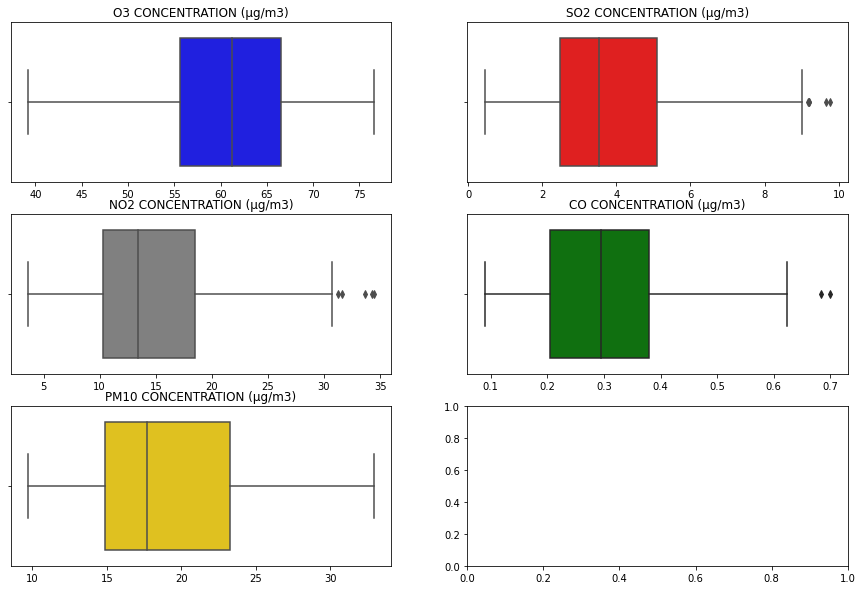

In [ ]:
vis.outliers_plot(air, "O3", "SO2", "NO2", "CO", "PM10")

The upper left plot represents ozone (O3) concentration, this graph confirms that there aren't any outliers, as no values are above or below the maximum and minimum value. 

The maximum ozone value is 76.55 µg/m3, its minimum 39.20 µg/m3 and its mean 60.52 µg/m3 for the 6 studied years (2014-2019). These values shown in the table are confirmed when using the function describe. These values are below the maximum allowable threshold stipulated by the capital's country (The below image showing their maximum limit has been taken from their official webpage). Care must be taken when reading this data as not all maximum values are shown by years. Some conversions must be required.

In [ ]:
# stats for all years combined
air.loc[air["POLLUTANT"]=="O3"].describe() 

,YEAR,VALUE
count,300.000000,300.000000
mean,2016.500000,60.520570
std,1.710679,7.266122
min,2014.000000,39.207032
25%,2015.000000,55.570881
50%,2016.500000,61.227735
75%,2018.000000,66.493071
max,2019.000000,76.551196


<table align="left"> 
<tr><td width="800"><img src="../resources/ozone_limits.PNG" style="width:500;height:500"></td> 
<td style="image-align:left"> 
</td></tr> 
</table>

The upper right plot shows Sulphur Dioxide (SO2) concentrations, where there are few outliers above the maximum value.

The maximum sulphur dioxide value is 9.77 µg/m3, its minimum 0.44 µg/m3 and its mean 3.97 µg/m3 for the 6 studied years (2014-2019). As before the limits stipulated by the governemnt has also been included for reference. 

This graph shows outliers so a deeper investigation is conducted to conclude how many they are and if they are relevant.

In [ ]:
# stats for all years combined
air.loc[air["POLLUTANT"]=="SO2"].describe() 

,YEAR,VALUE
count,299.000000,299.000000
mean,2016.505017,3.966500
std,1.711335,2.011419
min,2014.000000,0.445048
25%,2015.000000,2.489298
50%,2017.000000,3.530479
75%,2018.000000,5.094906
max,2019.000000,9.775640


<table align="left"> 
<tr><td width="800"><img src="../resources/so2_limits.PNG" style="width:500;height:500"></td> 
<td style="image-align:left"> 
</td></tr> 
</table>

Max value: 9.775640435089654


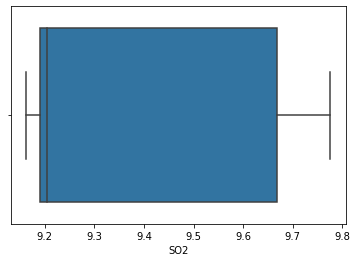

In [ ]:
vis.outliers(so2_mean, "SO2")

The number of outliers are also calculated to ensure not a lot of values are lost when removing them. In this case, there are 5 outliers over a 598 number of values, so it can be reasonable to ignore them.

In [ ]:
# First row shows values for SO2 concentration
# Second row values withour outliers
vis.outliers_calc(so2_mean)

(299, 3)


(294, 3)

The middle left plot shows Nitrogen Dioxide (NO2) concentrations, which also has few outliers above the maximum value. Similarly to the above outliers are calculated to have a better understanding of the obtained data.

The maximum sulphur dioxide value is 34.44 µg/m3, where the allowable value is stipulated as 40 µg/m3. Its minimum 3.61 µg/m3 and its mean 14.73 µg/m3 for the 6 studied years (2014-2019). 

In [ ]:
# stats for all years combined
air.loc[air["POLLUTANT"]=="NO2"].describe() 

,YEAR,VALUE
count,300.000000,300.000000
mean,2016.500000,14.736531
std,1.710679,6.041571
min,2014.000000,3.609716
25%,2015.000000,10.262409
50%,2016.500000,13.444916
75%,2018.000000,18.467335
max,2019.000000,34.444253


<table align="left"> 
<tr><td width="800"><img src="../resources/no2_limits.PNG" style="width:500;height:500"></td> 
<td style="image-align:left"> 
</td></tr> 
</table>

Max value: 34.444253477801304


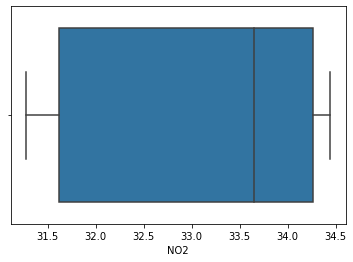

In [ ]:
vis.outliers(no2_mean, "NO2")

The outliners above the maximum value are 5 again, the difference between the original boxplot and the one without outliers. These are a number of values acceptable to not consider, so the study can process without considering them.

In [ ]:
# First row shows values for with outliers
# Second row values withour outliers
vis.outliers_calc(no2_mean)

(300, 3)


(295, 3)

The middle right shows Carbon Dioxide (CO) concentrations, with few outliers above the maximum value. 

The maximum sulphur dioxide value is 0.7 µg/m3, its minimum 0.09 µg/m3 and its mean 0.3 µg/m3 for the 6 studied years (2014-2019). 

In [ ]:
# stats for all years combined
air.loc[air["POLLUTANT"]=="CO"].describe() 

,YEAR,VALUE
count,251.000000,251.000000
mean,2016.494024,0.302442
std,1.712006,0.124647
min,2014.000000,0.089043
25%,2015.000000,0.204874
50%,2016.000000,0.294972
75%,2018.000000,0.378912
max,2019.000000,0.700000


<table align="left"> 
<tr><td width="800"><img src="../resources/co_limits.PNG" style="width:500;height:500"></td> 
<td style="image-align:left"> 
</td></tr> 
</table>

The lower left represents particles matters, with a diameter of 10 microns or less (PM10). This graph confirms that there aren't any outliers, as no values are above or below the maximum and minimum value.

The maximum ozone value is 32.94 µg/m3, its minimum 9.70 µg/m3 and its mean 18.87 µg/m3 for the 6 studied years (2014-2019).

In [ ]:
# stats for all years combined
air.loc[air["POLLUTANT"]=="PM10"].describe() 

,YEAR,VALUE
count,239.000000,239.000000
mean,2016.615063,18.868515
std,1.686060,5.304116
min,2014.000000,9.703704
25%,2015.000000,14.885639
50%,2017.000000,17.706091
75%,2018.000000,23.294444
max,2019.000000,32.943751


<table align="left"> 
<tr><td width="800"><img src="../resources/pm10_limits.PNG" style="width:500;height:500"></td> 
<td style="image-align:left"> 
</td></tr> 
</table>

From the above graphs it can be seen that gas concentration in Spain does not exceed the maximum acceptable values.

Now that it has been confirmed that all these values are within an acceptable range they can be plot to observe their evolution along the time. For this analysis all regions will be combined.

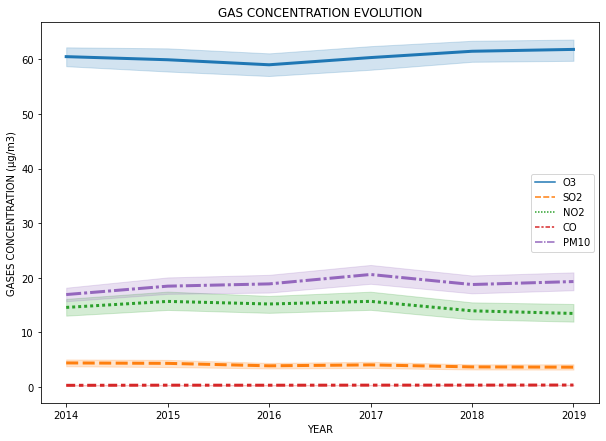

In [ ]:
vis.pollutant_evolution_all(air, "YEAR", "VALUE", "POLLUTANT", "POLLUTANT", "GASES")


From this combined table the evolution seems quite flat, so it is recommendable to study each pollutant one by one to understand better their changes, if any.

It seems O3 concentration in 2016 decreases compared to other years, but looking at the range, it cannot be considered as significant. Additionally, as this drop didnt continue over the time it cannot be considered as an improvement of air quality.

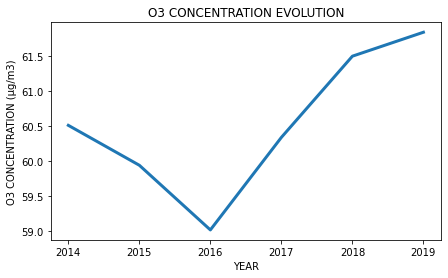

In [ ]:
# O3 concentration evolution
vis.pollutant_evolution_one(o3_mean, "O3")

The reduction in emissions since 1990 has been achieved as a result of a combination of measures, including fuel-switching in energy-related sectors away from high-sulphur solid and liquid fuels to low-sulphur fuels such as natural gas, the fitting of flue gas desulphurisation abatement technology in industrial facilities and the impact of European Union directives relating to the sulphur content of certain liquid fuels.

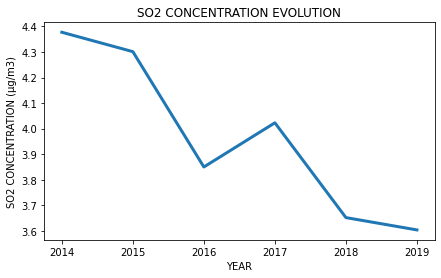

In [ ]:
# SO2 concentration evolution
vis.pollutant_evolution_one(so2_mean, "SO2")

Average NO2 concentrations have decreased over the years due to tougher environment regulations.

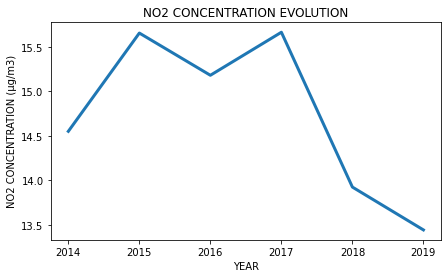

In [ ]:
# NO2 concentration evolution
vis.pollutant_evolution_one(no2_mean, "NO2")


The European Environment Agency states that CO concentration has decreased over time. The graph below shows the opposite, so it cannot be confirmed if Spain is an exception in Europe or the period of time analysed is not large enough to understand its evolution.

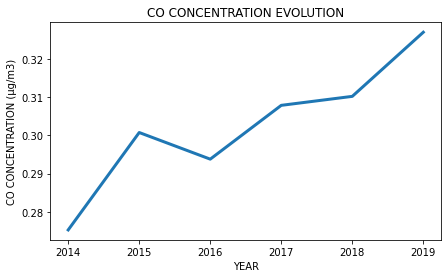

In [ ]:
# CO concentration evolution
vis.pollutant_evolution_one(co_mean, "CO")


PM10 emissions keep increasing over the time. They are strongly correlate with vehicular emission rates.

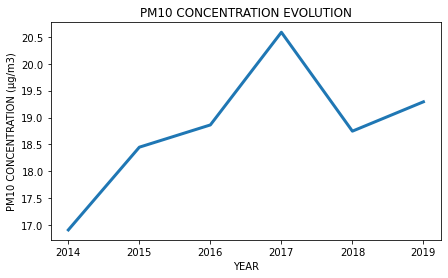

In [ ]:
# PM10 concentration evolution
vis.pollutant_evolution_one(pm10_mean, "PM10")


The above graphs shows how the gases concentration has changed along the years, but they dont specify the regions in the country where the highest values are. The below tree map plots are intended for this purpose.

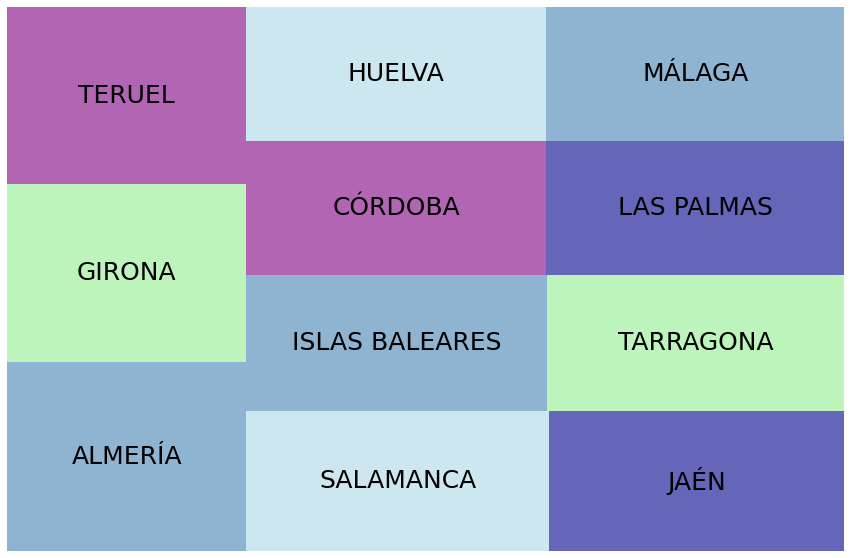

In [ ]:
# Tree map for O3
vis.tree_map(o3_mean, "O3")


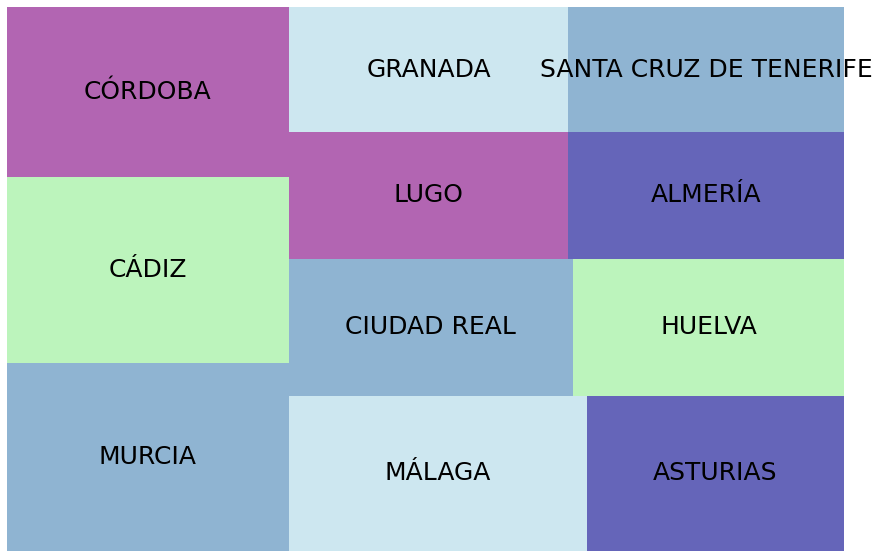

In [ ]:
# Tree map for SO2
vis.tree_map(so2_mean, "SO2")


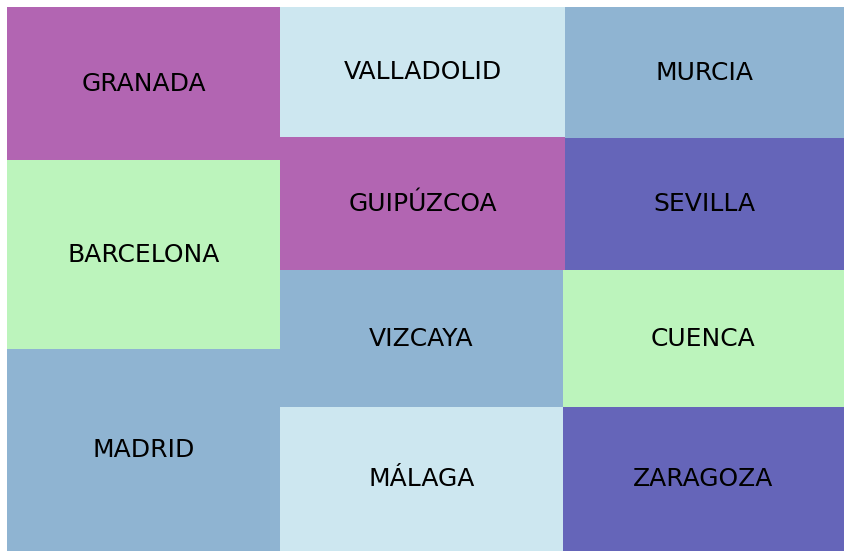

In [ ]:
# Tree map for NO2
vis.tree_map(no2_mean, "NO2")


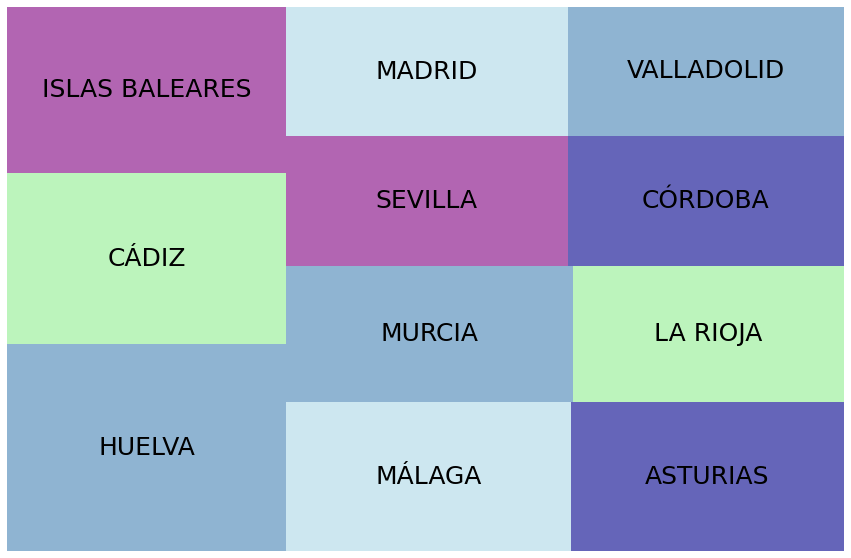

In [ ]:
# Tree map for CO
vis.tree_map(co_mean, "CO")


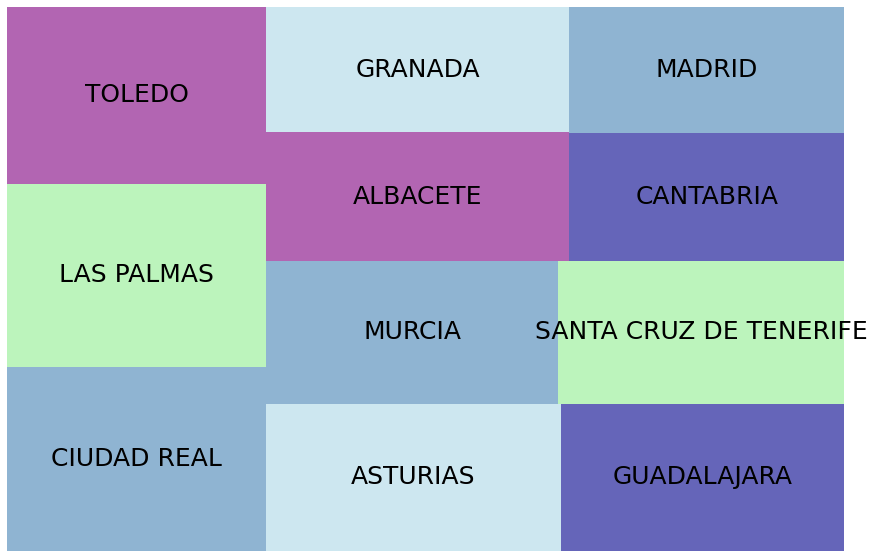

In [ ]:
# Tree map for PM10
vis.tree_map(pm10_mean, "PM10")


While it was expected for large cities to have a higher pollutant concentration these graphs shows that concentration values are pretty equal nation-wide.

Now that we have a better understanding about air pollutant statistics, below are plot some initial graphs for the temperature value.

The mean temperature for all studied years are plot together in the below grapth. Though some years were warmer than others, there aren't any extreme temperatures along the country.

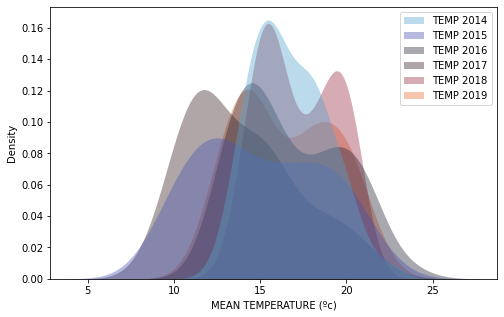

In [ ]:
vis.temp_plot(temp)

Ploting each year independingly the mean temperature can be seen more clearly, though data doesn't reveal nothing new. Temperatures are maintained pretty average along the year, with their maximum near the 15 degrees.

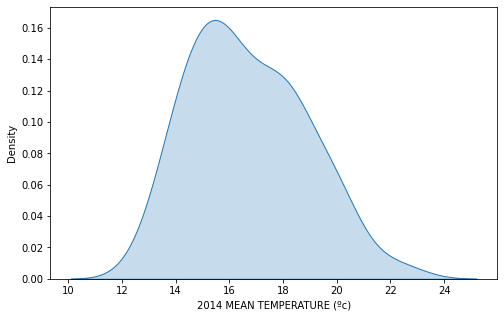

In [ ]:
# 2014
vis.temp_single(temp.T.iloc[:,0:1], 2014)   

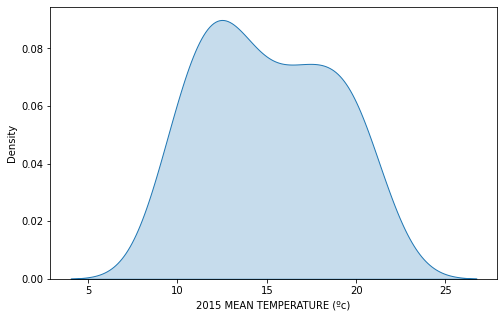

In [ ]:
# 2015
vis.temp_single(temp.T.iloc[:,1:2], 2015)

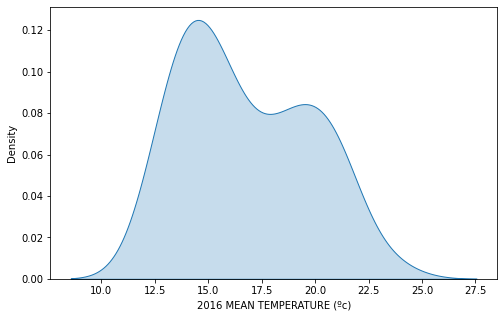

In [ ]:
# 2016
vis.temp_single(temp.T.iloc[:,2:3], 2016)

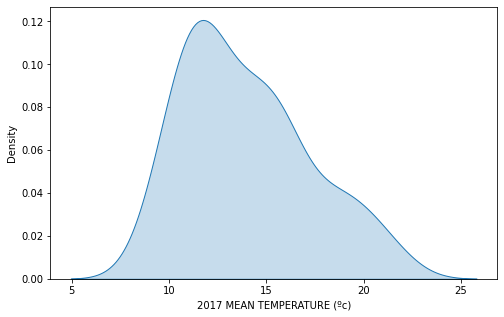

In [ ]:
# 2017
vis.temp_single(temp.T.iloc[:,3:4], 2017)

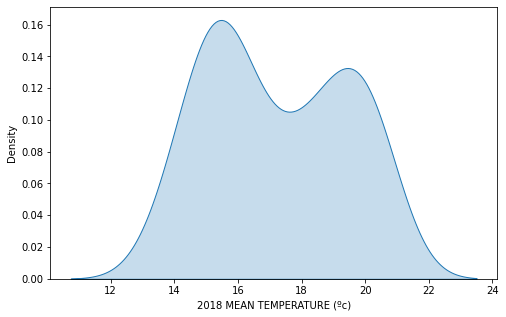

In [ ]:
# 2018
vis.temp_single(temp.T.iloc[:,4:5], 2018)

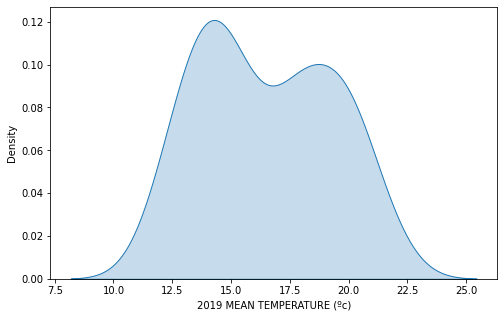

In [ ]:
# 2019
vis.temp_single(temp.T.iloc[:,5:6], 2019)   

One consequence and cause of climate change is that temperature is increasing over the years. It is possible to compare how temperature changes along the studied years in the country as a whole. From the below graph it is not possible to see a pattern or a change. Due to their ups and downs it can be concluded that a larger dataset was required as the variation in temperature needs to be studied over large periods of time. 

It makes sense when considering that a limit of 1.5°C has been set for 2034, and in the case of temperature reaching it would mean a bad scenario for climate change.

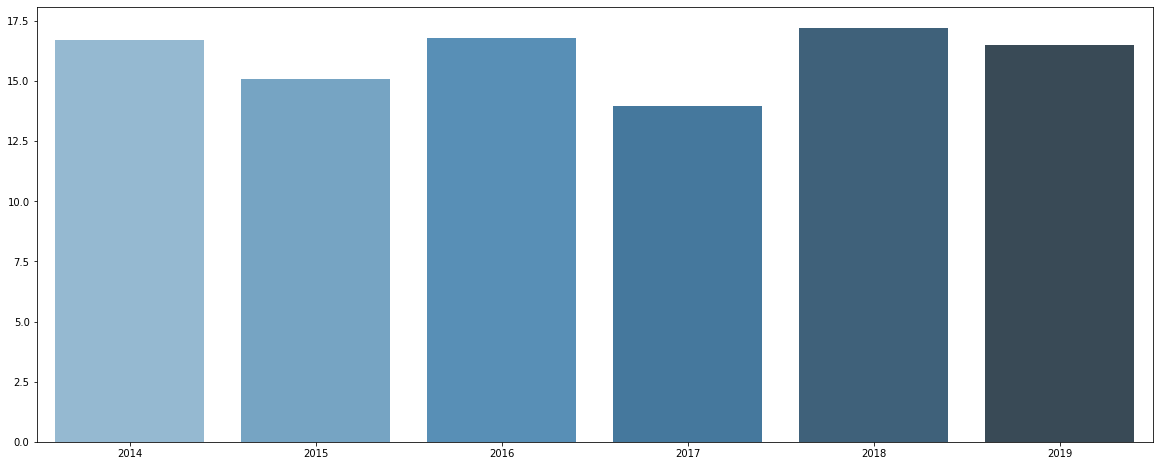

In [ ]:
temp_year = pd.DataFrame({"2014": temp.iloc[0].mean(), "2015": temp.iloc[1].mean(),   
                            "2016": temp.iloc[2].mean(), "2017": temp.iloc[3].mean(), 
                            "2018": temp.iloc[4].mean(), "2019": temp.iloc[5].mean()}, index=[0])
                      
vis.temp_country(temp_year)


Now that we have an idea of each value class, pollutants and temperature, let's compare them to see if there is any correlation between them. Though as just said it will be hard considering the limited available temperature data.

The below table shows there is no correlation at all between these two variables. The reason for this outcome could be either because they aren't actually related or because the data sample was too small.

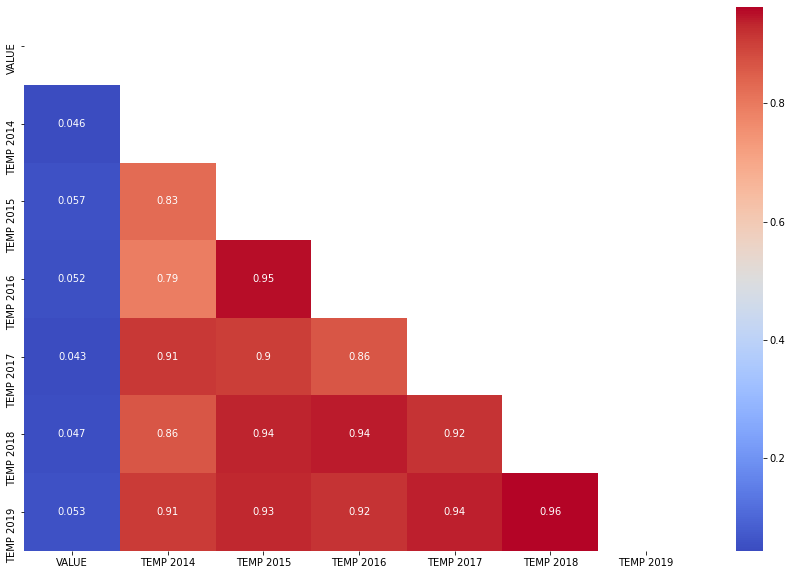

In [ ]:
vis.heatmap(final_df.iloc[:,3:])


Correlation between pollutants (represented as value in the above figure) and temperature does not exist. The only correlation shown in the graph is between the temperature of different years. However, these aren't two variables we can relate, they simply show a correlation because their values are similar.

### Conclusion

The studied data, and in particularly the correlation graph cannot show any relationship between temperature values and air quality. 

As there are scientific proofs confirming the increase in temperature impacts air quality negatively this EDA project concludes that the second answer is indeed the correct. The data sample wasn't large enough to obtain a reliable result, particularly when consdiering temperature changes. 

While it was determined that the dataset isn't adequate to draw any conclusions we cannot either confirm which pollutant is affected the most by temperature increases.

From the study data we can conclude that some pollutant such as SO2 and NO2 have been decreased over the years, but it is not possible to confirm if they will keep this trend and if it is enough to provide any release to climate change. On the other side, CO and PM10 keep increasing due to human activities over the years regardless temperature values.

Though this project couldn't confirm the initial hypothesis (the increase of temperature affects negatively air quality) it was interesting to understand that some harmful pollutants are indeed being decreased, and pollution levels are kept pretty average along the whole country. A further study can be done to understand the benefits of this reduction and what measures can be implemented to improve this trend.

Regardless temperature, more data is required to obtain a trend. Once this additional data is obtain it can also be possible to create a predictive model to foresee future temperatures and its consequences for air quality and climate change.

As requested as part of the project, all tendencies and a histogram with bins= 5 for each column of the dataframe have been plot below. Tendencies are represented by the line and the histogram is shown with 5 bars. Having bins= 5 means that data is grouped by 5 bins, so the highest value we assignate to bins the more detail the graph will show.

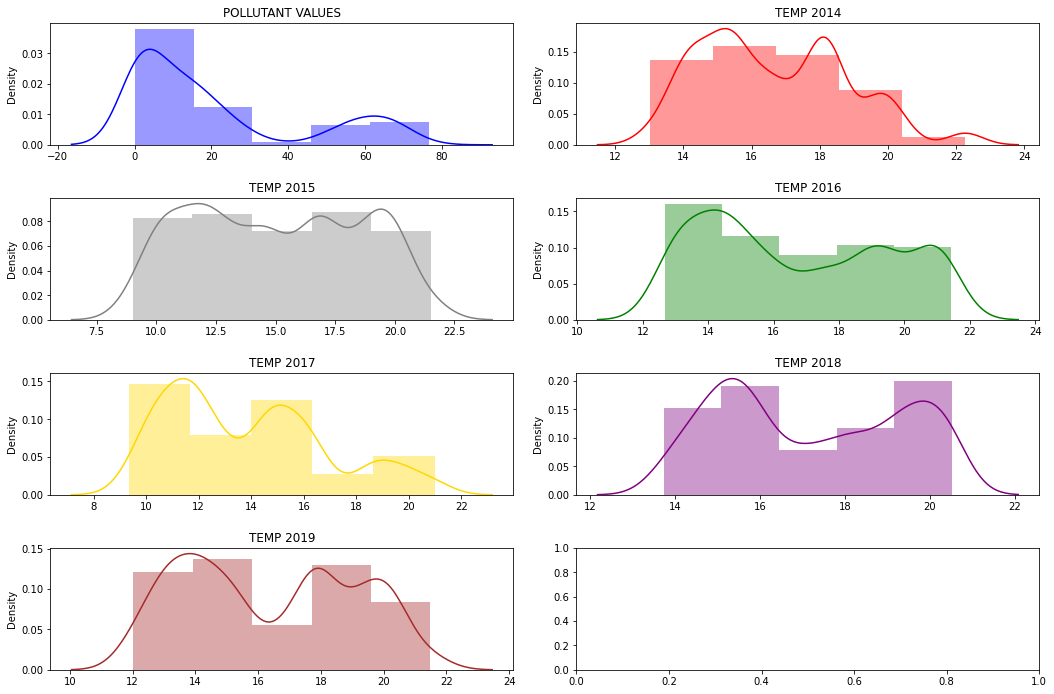

In [ ]:
vis.column_tendency(final_df.iloc[:,3:4], final_df.iloc[:,4:5], final_df.iloc[:,5:6], final_df.iloc[:,6:7], final_df.iloc[:,7:8], final_df.iloc[:,8:9], final_df.iloc[:,9:10])

After concluding the study the cleaned dataframe can also be inserted into a SQL dataframe.

In [ ]:
json_readed = read_json("utils","sql_setting")     

In [ ]:
#Import the password and all sensitive data from 'sql_setting.json'
mysql_db = MySQL(json_readed["IP_DNS"], json_readed["USER"], json_readed["PASSWORD"], json_readed["BD_NAME"], json_readed["PORT"])

mysql_db.connect()

Connected to MySQL server [71525533h_ds_april_2021_db]


In [ ]:
db_connection_str = mysql_db.SQL_ALCHEMY
db_connection = create_engine(db_connection_str)

In [ ]:
final_df.reset_index(inplace=True)
final_df.rename(columns={"index": "ID"}, inplace=True)

In [ ]:
final_df.to_sql("sonia_cobo_pacios", db_connection, index=False, if_exists="replace")

In [ ]:
# With SELECT it is possible to check if the table has been inserted correctly
select_sql = """SELECT * FROM sonia_cobo_pacios"""
select_result = mysql_db.execute_get_sql(sql=select_sql)
select_result

Executing:
 SELECT * FROM sonia_cobo_pacios


((0,
  'A CORUÑA',
  2014,
  'O3',
  58.1309705192761,
  15.52,
  14.94,
  16.195,
  12.975,
  16.240000000000002,
  15.225000000000001),
 (1,
  'A CORUÑA',
  2015,
  'O3',
  53.01298490842627,
  15.52,
  14.94,
  16.195,
  12.975,
  16.240000000000002,
  15.225000000000001),
 (2,
  'A CORUÑA',
  2016,
  'O3',
  54.59488617143487,
  15.52,
  14.94,
  16.195,
  12.975,
  16.240000000000002,
  15.225000000000001),
 (3,
  'A CORUÑA',
  2017,
  'O3',
  52.98030593690276,
  15.52,
  14.94,
  16.195,
  12.975,
  16.240000000000002,
  15.225000000000001),
 (4,
  'A CORUÑA',
  2018,
  'O3',
  59.358559116915394,
  15.52,
  14.94,
  16.195,
  12.975,
  16.240000000000002,
  15.225000000000001),
 (5,
  'A CORUÑA',
  2019,
  'O3',
  57.78414408798324,
  15.52,
  14.94,
  16.195,
  12.975,
  16.240000000000002,
  15.225000000000001),
 (6,
  'A CORUÑA',
  2014,
  'SO2',
  3.135707618987015,
  15.52,
  14.94,
  16.195,
  12.975,
  16.240000000000002,
  15.225000000000001),
 (7,
  'A CORUÑA',
  2015,

Now that the study is done we can also reply the below questions:

*a.Was it possible to demonstrate the hypothesis? Why?*

As explained in the conclusion above it was not possible to demonstrate the hypothesis due to the amount of data available. As the hypothesis was also strongly link to time a large period of time is also needed to discover any trend and/or patter. 

With data over the past 5 years it was not possible to confirm or deny the hypothesis. 

*b.What can you conclude about your data study?*

While the data seem to be accurate, as the period of time studied was quite short all values seem quite average which does not help to provide any conclusion.

Considering how temperature ranges over the years, few decimals can have a devastated impact to the environment it is reasonable to assume that the obtained data is correct and not sharp changes are reasonable in 5 years.

*c.What would you change if you need to do another EDA project?*

The main change would be in how data research and data mining was done before starting the project. As stated at the beginning, in the middle of the project a completely dataset was used due to the inconsistancy of the first one. This caused a big delay in the project and unnecessary additional work. It is extremely clear now that a deeper data investigation is required before starting the project to understand the available project data and determine if they are appropriate for the project. 

*d.What do you learn doing this project?*

Similar to the above, the main lesson has been on how to manage a project and how to determine and read a raw dataset before starting working with it. While some knowledge of python was acquire the main lesson was about time management, data research and project steps.

*Are there outliers or some rare data?*

Outliers were also analysed for pollutant concentrations. It was explain that there were only a few in some of them so it was not even worth it to go into a deeper study to confirm if they were real cases of gas concentration spiking on that time or were actual real data.

Apart from these all data seem consistent and the conclusion obtain after its analysis is reasonable.

*b.What are the columns that have more repeated values?*

The main dataframe contains different regions and different years. As temperature values were included in this table as the mean value per year, this is repeated in the rows for the same year even if there are different regions. 

This was done because this is a high level study, but if a more accurate research wanted to be done this praxis wouldn't have been carried out.